<center>
<a href="http://uf-mi.u-bordeaux.fr/MSS/" ><img src="https://www.math.u-bordeaux.fr/~jbigot/Site/Enseignement_files/logo_MAS_MSS.jpg" style="float:left; max-width: 400px; display: inline" alt="INSA"/></a> 

<a href="https://www.math.u-bordeaux.fr/" ><img src="https://www.math.u-bordeaux.fr/~jbigot/Site/Enseignement_files/LogoIMB.jpg" style="float:right; max-width: 250px; display: inline" alt="IMT"/> </a>
</center>

# <a href="https://www.python.org/"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/Python_logo_and_wordmark.svg/390px-Python_logo_and_wordmark.svg.png" style="max-width: 200px; display: inline" alt="Python"/></a> UE M2 Master MAS-MSS et CIMI ISI Projet Données Massives

# Algorithmes stochastiques pour la régression logistique avec <a href="https://www.python.org/"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/Python_logo_and_wordmark.svg/390px-Python_logo_and_wordmark.svg.png" style="max-width: 150px; display: inline" alt="Python"/></a> & <a href="http://scikit-learn.org/stable/#"><img src="http://scikit-learn.org/stable/_static/scikit-learn-logo-small.png" style="max-width: 180px; display: inline" alt="Scikit-Learn"/></a>
**Résumé**: 

Dans ce projet, vous devrez implémenter de trois algorithmes stochastiques pour la résolution d'un problème de régression logistique dans le cardre de classification supervisée binaire (à $K=2$ classes): 
- un algorithme de descente de gradient stochastique usuel tel que vous l'avez vu en cours
- l'algorithme ADAM : https://arxiv.org/pdf/1412.6980.pdf
- l'algorithme de Newton stochastique : https://arxiv.org/abs/1904.07908

Pour évaluer ces algorithmes, vous devrez les appliquer à trois problèmes de classification binaire différents:
- Des données 2D simulées
- La classification des images MNIST de taille 28 * 28
- La prédiction de présence d'éoliennes dans des images de taille 128 * 128 * 3
et plus comaprer leurs performances en terme de précision de la classification ainsi que de temps de convergence. 

Dand ce calepin, vous trouvrez les listes de travail pour vous aider à accomplir le rapport. Le rapport est à réaliser en jupyter notebook, avec le code et **la sortie**. 

**Versions de librairies**
- scikit-learn 1.0.2
- tensorflow 2.7.0

In [ ]:
! pip install --upgrade pip
! pip install -U scikit-learn
! pip install tensorflow 

In [2]:
import sklearn
import tensorflow as tf
print(sklearn.__version__) 
print(tf.__version__) 

1.0.2
2.7.0


Dans un premier temps, on rapelle la méthode de régression logistique, le problème d'optimisation sous-jacent et sa résolution par une implémentation disponible dans la package ``Scikit-Learn`` sur un exemple de données simulées en petite dimension pour $d=2$. On présente ensuite une approche par un réseau de neurones qui est équivalente à la régression logistique mais dont l'implémentation est basée sur un algorithme stochastique.

## Rappels sur la régression logistique et le problème d'optimisation sous-jacent

Il est supposé que l'on dispose d'un échantillon de $n$ observation $(X_i,Y_i)$ pour $1 \leq i \leq n$ où $X_i \in \mathbb{R}^{d}$ et $Y_i \in \{0,1\}$. Les observations sont modellisées comme des variables aléatoires indépendantes et de même loi qu'un couple aléatoire $(X,Y) \in \mathbb{R}^{d} \times \{0,1\}$.  Il s'agit du cadre standard de classification supervisée à $K=2$ classes (ici labellisées $\{0,1\}$), et le problème considéré est celui de la construction d'une règle de classification
$$
\hat{f} : \mathbb{R}^{d} \to \{0,1\},
$$
à partir de ces observations (ensemble d'apprentissage) dans le but de classer de nouvelles données $X^\prime \in \mathbb{R}^{d}$ dont on ne connait pas la classe d'appartenance.

### Régression logistique

Pour $x \in \mathbb{R}^{d}$, on introduit les probabilité conditionnelles

$$
p(x) = \mathbb{P}(Y=1 | X = x) = \mathbb{E}(Y | X=x)  \quad \mbox{et} \quad 1-p(x) = \mathbb{P}(Y=0 | X = x) = \mathbb{E}(1-Y | X=x).
$$

On rappelle que la régression logistique revient à considérer le modèle linéaire suivant :
$$
\log \left( \frac{p(x)}{1-p(x)} \right) = \theta_0 + \sum_{k=1}^{d} \theta_k x^{(k)} = \langle \theta , x\rangle,
$$
où $\langle \theta , x\rangle$ est le produit scalaire entre le vecteur de paramètres $\theta = (\theta_0, \theta_1,\ldots,\theta_d)$ et le vectur de données $x = (x^{(0)},x^{(1)},\ldots,x^{(d)})$ avec par convention $x^{(0)}=1$ pour prendre en compte le paramètre de biais (ou intercept) $\theta_0$. Ceci est équivant au modèle logistique
$$
p(x) = p_{\theta}(x) = \frac{\exp(\langle \theta , x\rangle)}{1+\exp(\langle \theta , x\rangle)}.
$$



L'estimation du vecteur de paramètres $\theta$ à partir de l'ensemble d'apprentissage est obtenu par maximisation de la vraisemblance
$$
L_{n}(\theta) = \prod_{i=1}^{n} \mathbb{P}(Y=Y_i | X = X_i)= \prod_{i=1}^{n} p_{\theta}(X_i)^{Y_i} (1-p_{\theta}(X_i))^{1-Y_i}, 
$$
ce qui est équivalent à minimizer l'opposé de la log-vraisemblance (normalisée par $1/n$)

$$
\mathcal{L}_{n}(\theta) = - \frac{1}{n}\sum_{i=1}^{n} \left[ Y_i \log(p_{\theta}(X_i)) + (1-Y_i) \log(1-p_{\theta}(X_i)) \right]= -\frac{1}{n}\sum_{i=1}^{n} \left[ Y_i \langle \theta , X_i \rangle - \log(1+\exp(\langle \theta , X_i \rangle)) \right],
$$
où par convention $X_i$ est un vecteur de $\mathbb{R}^{d+1}$ dont la première coordonnée est $x^{(0)}=1$. Remarquons que $-\left[ Y_i \log(p_{\theta}(X_i)) + (1-Y_i) \log(1-p_{\theta}(X_i)) \right]$ est la cross-entropy binaire entre la veritable classe de l'observation $i$ et la classe (probabilité) prédite. 

Il n'existe pas de solution explicite $\hat{\theta}$ à ce problème de maximisation. Toutefois, de nombreuses méthodes algorithmiques permettent d'en avoir une très bonne approximation numérique. Celles-ci se basent sur la connaissance du vecteur de gradient $\nabla \mathcal{L}_{n}(\theta) \in \mathbb{R}^{d+1}$ et de la matrice Hessienne $\nabla^2 \mathcal{L}_{n}(\theta) \in \mathbb{R}^{(d+1) \times (d+1)}$ de l'opposé de la log-vraisemblance donnés par

$$
\nabla \mathcal{L}_{n}(\theta) = -\frac{1}{n}\sum_{i=1}^{n} \left[Y_i X_i - \frac{\exp(\langle \theta , X_i \rangle)}{1+\exp(\langle \theta , X_i \rangle)}X_i\right]
$$
et
$$
\nabla^2 \mathcal{L}_{n}(\theta) = \frac{1}{n}\sum_{i=1}^{n}  \frac{1}{a_{i}(\theta)} X_iX_i^T,  \mbox{ avec } a_{i}(\theta) = \big(\exp(-\langle \theta , X_i \rangle /2)+\exp(\langle \theta , X_i \rangle /2)\big)^2
$$

Après avoir déterminé l'estimateur $\hat{\theta}$, une nouvelle observation $X^\prime \in \mathbb{R}^{d}$ est affectée à la classe $1$  si

$$
\frac{\exp(\langle \hat{\theta} , X^\prime\rangle)}{1+\exp(\langle \hat{\theta} , X^\prime\rangle)} \geq \frac{1}{2},
$$

et à la classe $0$ sinon. On fera attention au fait que, dans les calculs du produit scalaire $\langle \theta , X\rangle$, le vecteur $X^\prime$ est de dimension $d+1$ avec sa première composante égale à $x^{(0)}=1$.

Nous proposons d'illustrer la régression logistique sur un exemple de données simulées $X_1,\ldots,X_n$ à valeurs dans $\mathbb{R}^{2}$ à l'aide de fonctions disponibles dans la librairie `scikit-learn`.

(1000, 2)
(1000,)


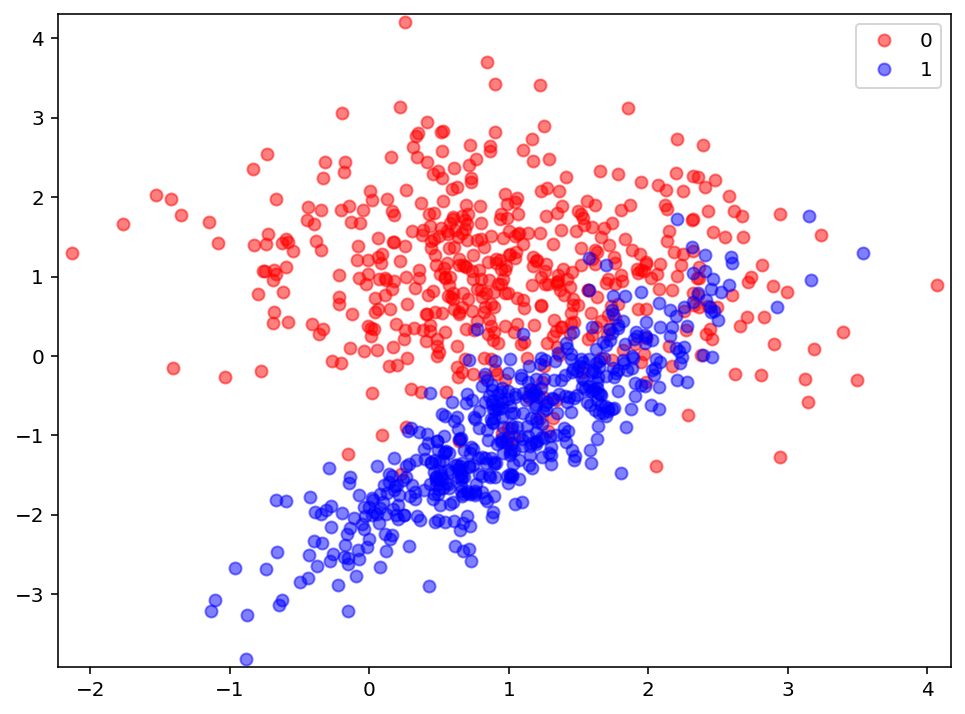

In [4]:
# Simulation de données appartenant à 2 classes

# Importation de librairies et fonctions
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

# Génération et visualisation de données
X, y = make_classification(n_samples=1000, n_features=2, n_redundant=0, 
                           n_informative=2, n_clusters_per_class=1, random_state = 600)

def plot_data(X, y, figsize=None):
    if not figsize:
        figsize = (8, 6)
    plt.figure(figsize=figsize)
    plt.plot(X[y==0, 0], X[y==0, 1], 'or', alpha=0.5, label=0)
    plt.plot(X[y==1, 0], X[y==1, 1], 'ob', alpha=0.5, label=1)
    plt.xlim((min(X[:, 0])-0.1, max(X[:, 0])+0.1))
    plt.ylim((min(X[:, 1])-0.1, max(X[:, 1])+0.1))
    plt.legend()
    
plot_data(X, y)
print(X.shape)
print(y.shape)

La classe qui implémente la régression logistique est ``sklearn.linear_model.LogisticRegression``. 

Consultons la page d'instruction: 
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

et comprenons les fonctionnalités de paramètres: **penalty**, **intercept_scaling**, et **slover**.

On peut constater qu'il y a plusieurs méthodes d'optimisation possibles pour déterminer numériquement le vecteur $\hat{\theta}$, et que la méthode par défaut ``lbfgs`` convient au cas sans pénalisation. 

In [5]:
import numpy as np
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty = 'none', random_state = 5)
lr.fit(X, y)
print('LR coefficients:', lr.coef_)
print('LR intercept:', lr.intercept_)

LR coefficients: [[ 1.32865076 -2.86107543]]
LR intercept: [-1.57121087]


Pour les données simulées, le code ci-dessus permet de déterminer un estimateur du vecteur $\theta$ dans le modèle de régression logistique. Remarquons que la valeur de $\hat{\theta}_{(0)}$ est donnée par ``lr.intercept_`` et celle de $(\hat{\theta}_{(1)},\hat{\theta}_{(2)})$ par ``lr.coef_``.

On trace ensuite la règle de classification ainsi obtenue.

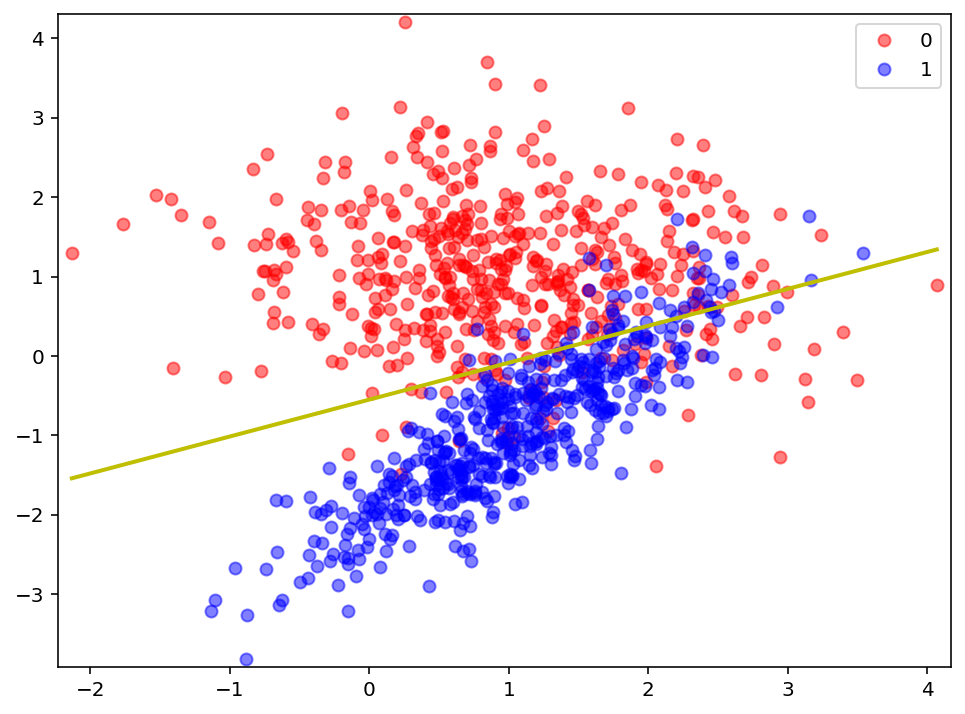

In [6]:
plot_data(X, y)

limits = np.array([np.min(X[:,0]), np.max(X[:,0])])
boundary = -(lr.coef_[0][0] * limits + lr.intercept_[0]) / lr.coef_[0][1]
plt.plot(limits, boundary, "y-", linewidth=2)

### Réseau de neurones à une seule couche

La formulation du modèle de régression logistique peut également s'interpréter comme la construction d'un réseau de neurones à une seule couche (les entrées) avec un seul neurone de sortie, et l'utilisation de la sigmoïde comme fonction d'activation ainsi que de la cross-entropy comme terme d'attache aux données. 

Essayez de constuire un tel reseau avec Keras, et sa classe ``sequential``, en consultant la page d'instruction: 
https://keras.io/api/models/sequential/

L'optimisation est implémentée en autonomie par Keras, avec la plupart des algorithmes du machine learning disponibles et à choisir. Dans ce exemple, on utilise l'algorithme de descente de gradient stochastique ``ADAM``.

In [ ]:
# Définition du réseau de neurones
model = tf.keras.Sequential()
model.add( ... )

opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss= ... , metrics=['accuracy'])

# Verfiez le structure du reseau
model.summary()

<Figure size 576x432 with 0 Axes>

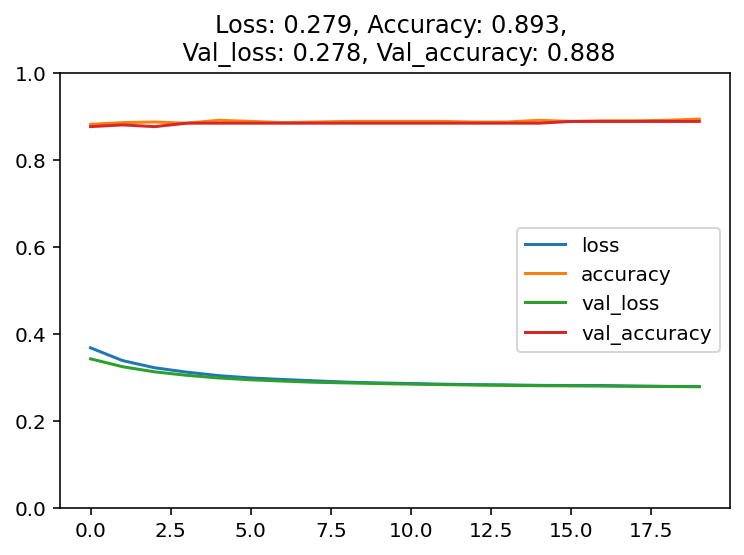

In [106]:
# Descente de gradient stochastique pour l'estimation des paramètres
# 75 % des données sont gardées pour la phase d'entrainement
# 25 % des données sont gardées pour la phase de test
#help(model.fit)
history = model.fit(x=X, y=y, batch_size= 30, verbose=0, epochs=20, validation_split=0.25)

import pandas as pd

# Définition d'une fonction de représentation graphique
def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['accuracy'][-1]
    val_loss = history.history['val_loss'][-1]
    val_acc = history.history['val_accuracy'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f, \n Val_loss: %.3f, Val_accuracy: %.3f' % (loss, acc, val_loss, val_acc))
    
plot_loss_accuracy(history)

Apres l'entrainement, on peut avoir accès à la valeur du paramètre $\hat{\theta}$ calculée par l'algorithme ``ADAM``à l'aide du code ci-dessous. 

In [107]:
print(model.weights)

weights = model.get_weights()

print(weights[0]) # theta_1 et theta2
print(weights[1]) # theta_0 (Intercept ou terme de biais)

# Résultats de la procédure de régression logistique
print('LR coefficients:', lr.coef_)
print('LR intercept:', lr.intercept_)

[<tf.Variable 'dense_20/kernel:0' shape=(2, 1) dtype=float32, numpy=
array([[ 0.8800773],
       [-2.5845459]], dtype=float32)>, <tf.Variable 'dense_20/bias:0' shape=(1,) dtype=float32, numpy=array([-0.8808409], dtype=float32)>]
[[ 0.8800773]
 [-2.5845459]]
[-0.8808409]
LR coefficients: [[ 1.32865076 -2.86107543]]
LR intercept: [-1.57121087]


Tracez la frontière obtenue et comparez la avec celle de la régression logistique

In [ ]:
# TODO

##  <span style="color:red"> Travail pour le rapport </style>

## 1 Implémentation de trois algorithmes stochastiques pour des données simulées

Dans cette partie, on vous demande d'implémenter les trois algorithmes stochastiques décrits dans l'introduction du projet et de comparer les résultats obtenus avec ceux de la section précédente sur des données simulées en dimension $d=2$.

In [122]:
from pylab import *
import os 

In [123]:
# Nombre de données
n = len(y)

# Ajout d'une colonne de 1 à la matrice X
X1 = np.c_[np.ones((n,1)),X]
y1 = y

In [124]:
# Partage des données en un ensemble d'apprentissage et un ensemble de test
from sklearn import model_selection

X1_train, X1_test, y1_train, y1_test, = model_selection.train_test_split(X1,y1, test_size=.25)

print(X1_train.shape)
print(X1_test.shape)
print(y1_train.shape)
print(y1_test.shape)

(750, 3)
(250, 3)
(750,)
(250,)


### 1.1 Algorithme de descente de gradient stochastique

$$
\mathcal{L}_{n}(\theta) = \frac{1}{n} \sum_{i=1}^{n} f(\underbrace{X_i,Y_i}_{Z_i},\theta),
$$
où $f(X_i, Y_i,\theta) = - \left[ Y_i \langle \theta , X_i \rangle - \log(1+\exp(\langle \theta , X_i \rangle)) \right]$ est la cross-entropy binaire entre la classe de l'observation $i$ et celle de sa prévision. 

Sa version population:
$$
\mathcal{L}(\theta) = \mathbb{E} \left[f(X, Y,\theta) \right],
$$
Si l'on suppose que le modèle logistique est le vrai modèle pour les données avec la constante $\theta^*$, i.e. $\mathbb{P}(Y = 1 | X) = \langle \theta^*, X\rangle$. Alors, $\theta^*$ minimise l'esperance $\mathcal{L}(\theta)$.  Etant donné les observations $(X_i, Y_i)_{i = 1}^n$, la meilleure estimation$^1$ de $\theta^*$ est le minimiseur de $\mathcal{L}_{n}(\theta)$. 

*$^1$ dans le sens de la minimisation de la vraisemblance.*

Mais quand $n$ est grand, il coût cher d'utiliser les algorithmes **Batch**, ctd chaque iteration demande le calcul de gradient sur tous les observations, $\frac{1}{n} \sum_{i = 1}^n \nabla_{\theta} f(Z_{i},\theta)$.  

- Coût du temp; 
- La presence de l'ensemble d'aprentissage dans une espace, e.g. coût du stockage, calcul impossiple en temps réel.

Les algorithmes stochastiques sont proposés pour ce scénario de l'estimation du $\theta^*$. Dans un premier temps, on utilise la descente de gradient stochastique (SGD) et sa variant mini-batch gradient descent. 


**SGD (une epoch):** 

*Initialisation* : choix de $\hat{\theta}^{(0)} \in \mathbb{R}^{d+1}$

*Répéter pour $1 \leq k \leq n$*

$$
\hat{\theta}^{(k)} = \hat{\theta}^{(k-1)} - \gamma_k \nabla f(X_k,Y_k,\hat{\theta}^{(k-1)})
$$

où pour un couple de données $(X,Y) \in \mathbb{R}^{d+1} \times \{0,1\}$, on définit

$$
\nabla f(X,Y,\theta) = - Y X + \frac{\exp(\langle \theta , X \rangle)}{1+\exp(\langle \theta , X \rangle)}X
$$

et $(\gamma_k)_{k \geq 1}$ est une suite de pas décroissants qui sont généralement choisis de la forme

$$
\gamma_k = c k^{-\alpha},
$$

avec $1/2 < \alpha \leq 1$ et $c > 0$ une constante à calibrer de façon judicieuse.


**Mini-batch GD (une epoch)**

Il est également possible de partionner les données en une suite de mini-batch à $M$ échantillons, dans le but d'avoir une meilleure estimation (en terme de variance) du gradient de $\mathcal{L}$ à chaque itération. 

*Initialisation* : choix de $\hat{\theta}^{(0)} \in \mathbb{R}^{d+1}$, de taille du batch $M$

$$
\underbrace{Z_1,\ldots,Z_{M}}_{B_1 = \{1,\ldots,M\}}, \quad \underbrace{Z_{M+1},\ldots,Z_{2M}}_{B_2 = \{M,\ldots,2M\}}, \quad\underbrace{Z_{2M+1},\ldots,Z_{3M}}_{B_3 = \{2M+1,\ldots,3M\}}, \quad \ldots
$$

*Répéter pour $1 \leq k \leq \frac{n}{M}$*

$$
\hat{\theta}^{(k)} = \hat{\theta}^{(k-1)} - \gamma_k \left( \frac{1}{M} \sum_{i \in B_{l}} \nabla f(X_{i},Y_{i},\hat{\theta}^{(k-1)}) \right)
$$

----
Niveau théorique, pour montrer la convergence d'algo, on suppose qu'on a des observations infinies, donc on répète pas d'échantillon. Mais, en pratique, c'est une autre histoire, les données sont toujours limitées, donc on peut traverser le jeu des données plusieurs fois. Maintenant, on transfère les algos ici à la version multi-epochs.

----


**SGD:** 

*Initialisation* : choix de $\hat{\theta}^{(0)} \in \mathbb{R}^{d+1}$ et **du nombre d'epochs à effectuer $n\_ epoch$**

***Répéter pour $1 \leq t \leq n\_ epoch$***

*Permutation au harsard de l'ensemble d'apprentissage, dont nouveau ordre noté par $(X_{t_1}, Y_{t_1}), ..., (X_{t_n},  Y_{t_n})$*

*Répéter pour $1 \leq i \leq n$*

**$k = (t-1)*n + i$**

$$
\hat{\theta}^{(k)} = \hat{\theta}^{(k-1)} - \gamma_k \nabla f(X_{t_i},Y_{t_i},\hat{\theta}^{(k-1)})
$$

où pour un couple de données $(X,Y) \in \mathbb{R}^{d+1} \times \{0,1\}$, on définit

$$
\nabla f(X,Y,\theta) = - Y X + \frac{\exp(\langle \theta , X \rangle)}{1+\exp(\langle \theta , X \rangle)}X
$$

et $(\gamma_k)_{k \geq 1}$ est une suite de pas décroissants qui sont généralement choisis de la forme

$$
\gamma_k = c k^{-\alpha},
$$

avec $1/2 < \alpha \leq 1$ et $c > 0$ une constante à calibrer de façon judicieuse.

**Mini-batch GD**

*Initialisation* : choix de $\hat{\theta}^{(0)} \in \mathbb{R}^{d+1}$, de taille du batch $M$ et **du nombre d'epochs à effectuer $n\_ epoch$**

***Répéter pour $1 \leq t \leq n\_ epoch$***

**Permutation au harsard de l'ensemble d'apprentissage, dont nouveau ordre noté par $\underbrace{(X_{t_1}, Y_{t_1})}_{Z_{t_1}}, \ldots, \underbrace{(X_{t_n}, Y_{t_n})}_{Z_{t_n}}$**

**Former les mini-batchs de nouveau**
$$
\underbrace{Z_{t_1},\ldots,Z_{t_M}}_{B_1 = \{t_1,\ldots,t_M\}}, \quad \underbrace{Z_{t_{M+1}},\ldots,Z_{t_{2M}}}_{B_2 = \{t_M,\ldots,t_{2M}\}}, \quad\underbrace{Z_{t_{2M+1}},\ldots,Z_{t_{3M}}}_{B_3 = \{t_{2M+1},\ldots,t_{3M}\}}, \quad \ldots
$$

*Répéter pour $1 \leq l \leq \frac{n}{M}$*

**$k = (t-1)*\frac{n}{M} + l$**

$$
\hat{\theta}^{(k)} = \hat{\theta}^{(k-1)} - \gamma_k \left(\frac{1}{M} \sum_{i \in B_{l}} \nabla f(X_{i}, Y_{i}, \hat{\theta}^{(k-1)}) \right)
$$

### Travail à réaliser

Implémentez le mini-batch GD sur l'ensemble d'appretissage et faites varier les hyper-paramètres, e.g. $\mbox{n_epoch} = 20, \mbox{batch_size} = 10, \alpha = 0.5, c = 10$

Pour le meilleur combinaison de hyperparamètres que vous avez trouvée, ctd laquelle qui donne le plus petit erreur de prévision sur l'ensemble de test:

**Evaluation**

1. tracez la fontière obtenue de classification avec tous les données et comparez-la avec la fontière de la régression logistique

2. tracez les indicateurs de performance, plus exactement

 - relevez le temps d'exécution de chaque itération
 
 A la fin de chaque itération $k$, avec le dernier $\hat{\theta}^{(k)}$
 - prédisez les classes des tous echantillons dans l'ensemble d'appretissage et culculez le taux d'erreur train
 - prédisez les classes des tous echantillons dans l'ensemble test et culculez le taux d'erreur test 
 - calculez la loss i.e. l'opposé de log-vraisemblance train (utiliser tous les echantillons dans l'ensemble d'appretissage)
 - calculez la loss i.e. l'opposé de log-vraisemblance test (utiliser tous les echantillons dans l'ensemble test)

 tracez ainsi: 
 - l'évolution du taux d'erreur train / test en fonction des itérations
 - l'évolution du taux d'erreur train / test en fonction des temps
 - l'évolution de la vraisemblance train / test en fonction des itérations 
 - l'évolution de la vraisemblance train / test en fonction des temps